In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import re
import string

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.style.use('seaborn-v0_8-whitegrid')

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, classification_report, roc_auc_score
from sklearn.inspection import permutation_importance

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from textblob import TextBlob
from wordcloud import WordCloud

import joblib

In [2]:
!ls /kaggle/input

tokopedia-product-reviews-2025


In [3]:
data_path = "/kaggle/input/tokopedia-product-reviews-2025"

In [4]:
data = pd.read_csv(os.path.join(data_path, "tokopedia_product_reviews_2025.csv"))
print(f"Data have: {data.shape[0]} rows and {data.shape[1]} columns")

Data have: 65543 rows and 13 columns


In [5]:
data.head()

,review_text,review_date,review_id,product_name,product_category,product_variant,product_price,product_url,product_id,rating,sold_count,shop_id,sentiment_label
0,baru sekali ini terima brg dr belanja online d...,2024-12-22,1134256160,Telur Ayam Kampung Asli - Telur Mengandung Ome...,Makanan & Minuman,Box Polos,87000,https://www.tokopedia.com/indofarmproduct/telu...,4601033481,5,1000000,8672687,positive
1,cocok bgt aku sama telur nya. nga Amis menurut...,2025-02-25,1242584634,Telur Ayam Kampung Asli - Telur Mengandung Ome...,Makanan & Minuman,Box Polos,87000,https://www.tokopedia.com/indofarmproduct/telu...,4601033481,5,1000000,8672687,positive
2,Telornya sudah sampai di rumah dengan kemasan ...,2025-07-15,1573444677,Telur Ayam Kampung Asli - Telur Mengandung Ome...,Makanan & Minuman,Box Polos,87000,https://www.tokopedia.com/indofarmproduct/telu...,4601033481,5,1000000,8672687,positive
3,Telor sudah diterima dengan baik dan tidak ada...,2025-07-20,1581728541,Telur Ayam Kampung Asli - Telur Mengandung Ome...,Makanan & Minuman,Box Polos,87000,https://www.tokopedia.com/indofarmproduct/telu...,4601033481,5,1000000,8672687,positive
4,"Alhamdulillah penjual amanah,Telor nya terbaik...",2023-04-24,881041355,Telur Ayam Kampung Asli - Telur Mengandung Ome...,Makanan & Minuman,Box Full Design,87000,https://www.tokopedia.com/indofarmproduct/telu...,4601033481,5,1000000,8672687,positive


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65543 entries, 0 to 65542
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   review_text       65543 non-null  object
 1   review_date       65543 non-null  object
 2   review_id         65543 non-null  int64 
 3   product_name      65543 non-null  object
 4   product_category  65543 non-null  object
 5   product_variant   26749 non-null  object
 6   product_price     65543 non-null  int64 
 7   product_url       65543 non-null  object
 8   product_id        65543 non-null  int64 
 9   rating            65543 non-null  int64 
 10  sold_count        65543 non-null  int64 
 11  shop_id           65543 non-null  int64 
 12  sentiment_label   65543 non-null  object
dtypes: int64(6), object(7)
memory usage: 6.5+ MB


#### Check for NA values

In [7]:
data.isna().sum()

review_text             0
review_date             0
review_id               0
product_name            0
product_category        0
product_variant     38794
product_price           0
product_url             0
product_id              0
rating                  0
sold_count              0
shop_id                 0
sentiment_label         0
dtype: int64

`product_variant` have '38794' null/na values

#### Convert 'review_date' to datetime

In [8]:
data['review_date'] = pd.to_datetime(data['review_date'], errors='coerce')


#### Check date range

In [9]:
print(f"Date Range: {data['review_date'].min()} to {data['review_date'].max()}")

Date Range: 2015-11-18 00:00:00 to 2025-12-12 00:00:00


#### Fill missing text values if any (simple imputation)

In [10]:
data['review_text'] = data['review_text'].fillna('')
data['product_variant'] = data['product_variant'].fillna('Unknown')

#### Feature Engineering: Review Length & Month-Year

In [11]:
data['review_length'] = data['review_text'].apply(lambda x: len(str(x)))
data['word_count'] = data['review_text'].apply(lambda x: len(str(x).split()))
data['month_year'] = data['review_date'].dt.to_period('M')

display(data[['review_text', 'review_length', 'word_count', 'month_year']].head())

,review_text,review_length,word_count,month_year
0,baru sekali ini terima brg dr belanja online d...,205,34,2024-12
1,cocok bgt aku sama telur nya. nga Amis menurut...,113,20,2025-02
2,Telornya sudah sampai di rumah dengan kemasan ...,112,16,2025-07
3,Telor sudah diterima dengan baik dan tidak ada...,86,13,2025-07
4,"Alhamdulillah penjual amanah,Telor nya terbaik...",145,18,2023-04


#### Dsitribution of reviews among product category

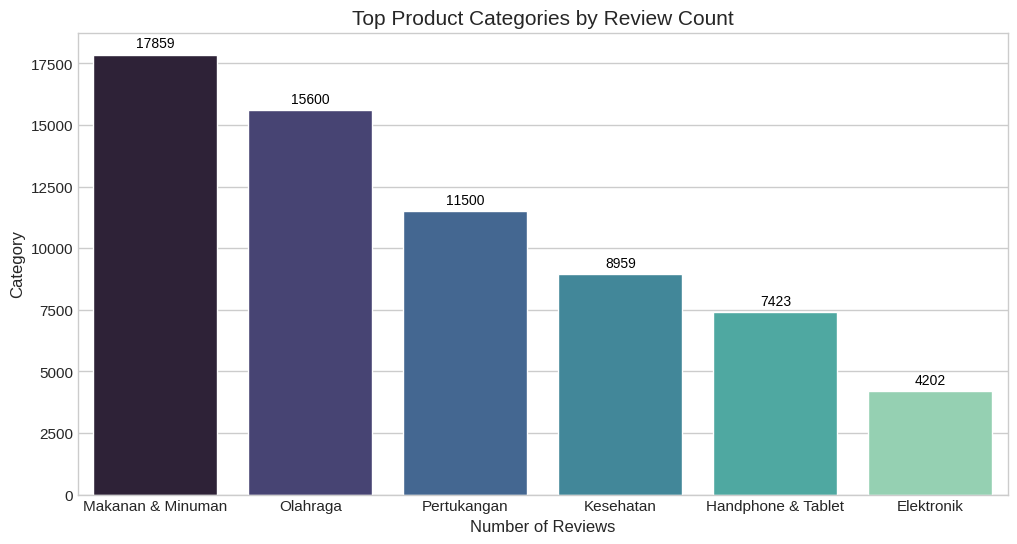

In [12]:
top_categories = data['product_category'].value_counts().head(10)

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=top_categories.index, y=top_categories.values, palette='mako')
plt.title('Top Product Categories by Review Count', fontsize=15)
plt.xlabel('Number of Reviews', fontsize=12)
plt.ylabel('Category', fontsize=12)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5), 
                textcoords='offset points')
plt.show()

#### Let's see the distribution of star ratings (1 to 5).

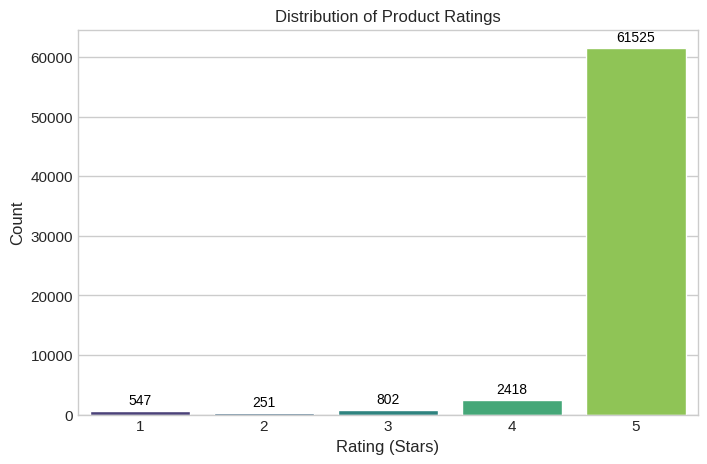

In [13]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='rating', data=data, palette='viridis')
plt.title('Distribution of Product Ratings')
plt.xlabel('Rating (Stars)')
plt.ylabel('Count')

# Add labels
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5), 
                textcoords='offset points')
plt.show()


#### Sentiment Label Distribution

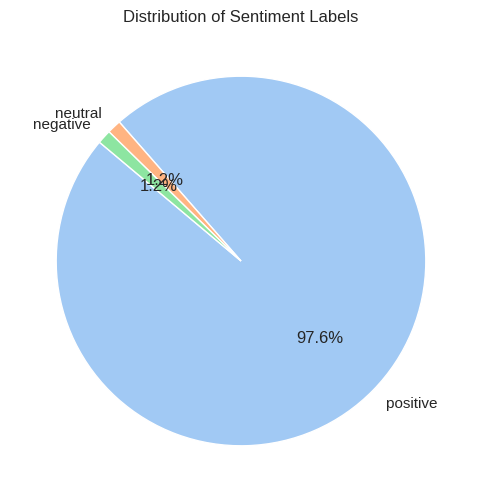

In [14]:
plt.figure(figsize=(6, 6))
sentiment_counts = data['sentiment_label'].value_counts()
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('Distribution of Sentiment Labels')
plt.show()


#### Analyze the price range of products reviewed.

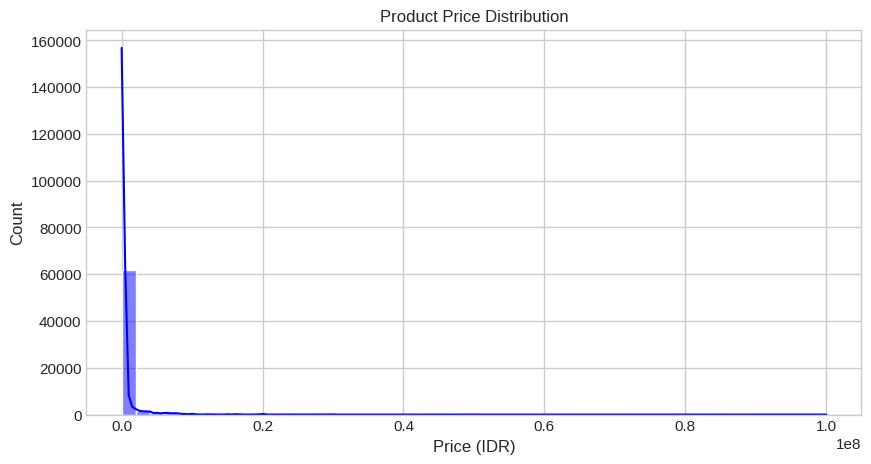

In [15]:
plt.figure(figsize=(10, 5))
sns.histplot(data['product_price'], bins=50, kde=True, color='blue')
plt.title('Product Price Distribution')
plt.xlabel('Price (IDR)')
plt.show()


### Rating vs Sentiment
Do higher ratings always correspond to 'positive' sentiment labels?


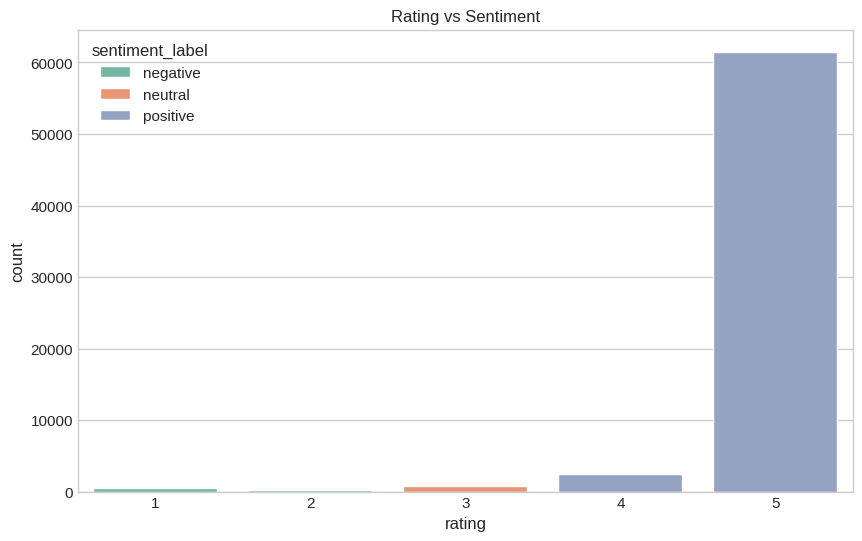

In [16]:
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', hue='sentiment_label', data=data, palette='Set2')
plt.title('Rating vs Sentiment')
plt.show()


#### Review Length vs Sentiment
Do angry customers write longer reviews?

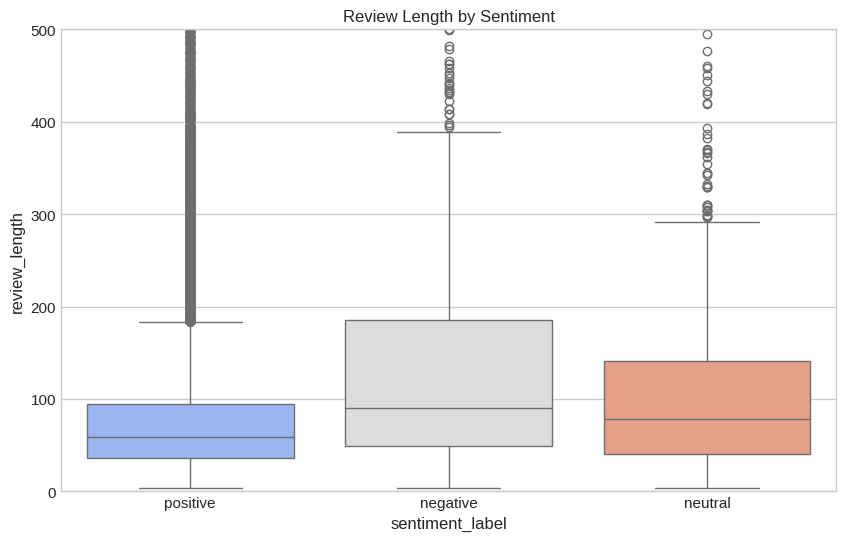

In [17]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='sentiment_label', y='review_length', data=data, palette='coolwarm')
plt.title('Review Length by Sentiment')
plt.ylim(0, 500) # Limiting y-axis to focus on common review lengths
plt.show()


#### Number of reviews over time.

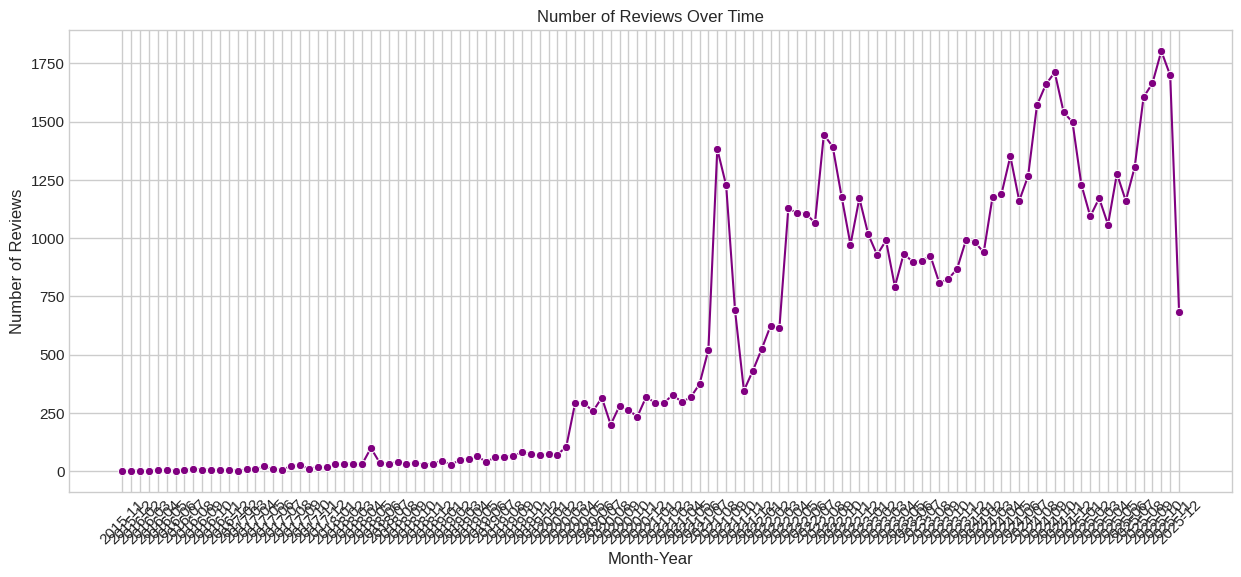

In [18]:
reviews_over_time = data.groupby('month_year').size()
reviews_over_time.index = reviews_over_time.index.astype(str)

plt.figure(figsize=(15, 6))
sns.lineplot(x=reviews_over_time.index, y=reviews_over_time.values, marker='o', color='purple')
plt.xticks(rotation=45)
plt.title('Number of Reviews Over Time')
plt.ylabel('Number of Reviews')
plt.xlabel('Month-Year')
plt.grid(True)
plt.show()

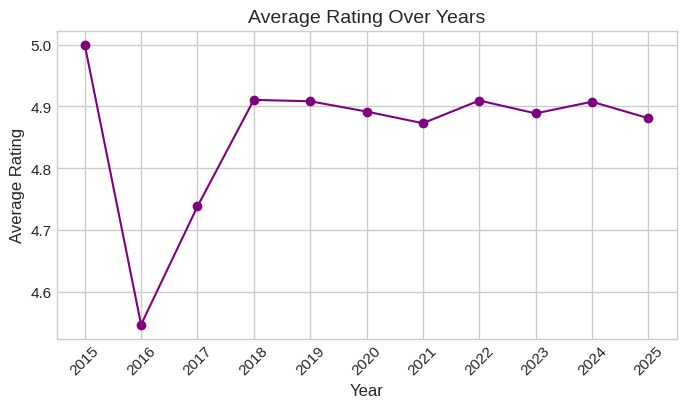

In [19]:
data['year'] = data['review_date'].dt.year

yearly_rating = data.groupby('year')['rating'].mean()

plt.figure(figsize=(8,4))
yearly_rating.plot(marker='o', linestyle='-', color='purple')
plt.title('Average Rating Over Years', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)
plt.xticks(yearly_rating.index, rotation=45)
plt.grid(True)
plt.show()

#### Text Analysis

In [20]:
def plot_wordcloud(text, title):
    wc = WordCloud(width=800, height=400, background_color='white', stopwords=None, min_font_size=10).generate(text)
    plt.figure(figsize=(10, 5))
    image_array = np.array(wc.to_image()) # Explicit conversion to avoid numpy/wordcloud bug
    plt.imshow(image_array, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=15)
    plt.show()

Generating Word Clouds...


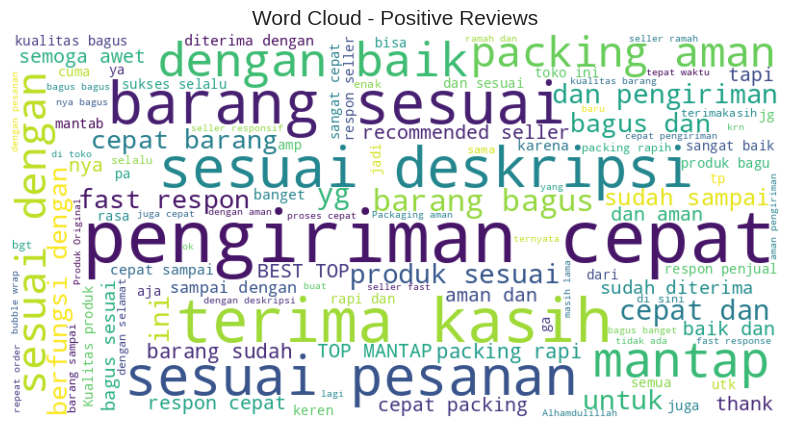

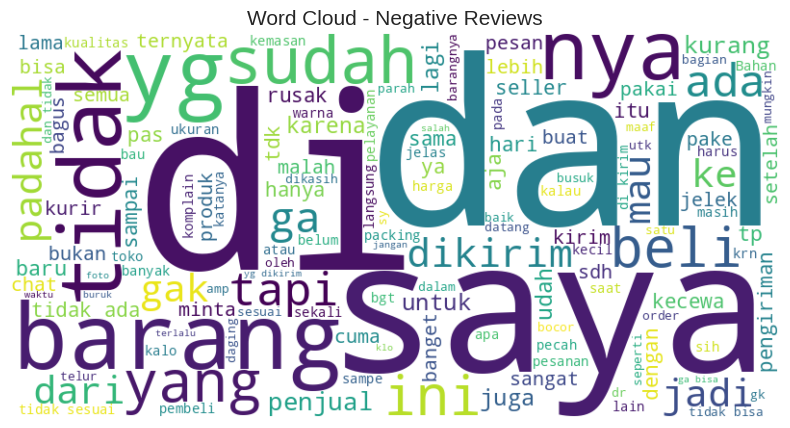

In [21]:
positive_text = ' '.join(data[data['sentiment_label'] == 'positive']['review_text'].astype(str))
negative_text = ' '.join(data[data['sentiment_label'] == 'negative']['review_text'].astype(str))

# Plot
print("Generating Word Clouds...")
try:
    plot_wordcloud(positive_text, "Word Cloud - Positive Reviews")
    plot_wordcloud(negative_text, "Word Cloud - Negative Reviews")
except Exception as e:
    print(f"Skipping wordcloud due to error: {e}")


**Text Insights:**
*   Positive reviews often contain words like 'pengiriman`, `cepat`, `barang`, `terima`, `kasih`.
*   Negative reviews might highlight issues like 'saya', 'dan', 'sudah', 'todak'.


#### Top 5 Most Reviewed Products

In [22]:
top_products = data['product_name'].value_counts().head(5).reset_index()
top_products

,product_name,count
0,Chosamon Mid Top Original Sepatu Sneakers Olah...,80
1,Telur Omega 3 Organik - INDOFARM Smart Eggs,60
2,Telur Ayam Kampung Asli - Telur Mengandung Ome...,60
3,TELUR NEGERI 10 PCS,51
4,BETADINE OBAT KUMUR ANTISEPTIK 190 ML,42


#### Which products have the worst average rating? (Min 10 reviews)

In [23]:
product_ratings = data.groupby('product_name').agg({'rating': 'mean', 'review_id': 'count'})
worst_products = product_ratings[product_ratings['review_id'] > 10].sort_values(by='rating').head(5).reset_index()
worst_products

,product_name,rating,review_id
0,Net Volly Jaring Net Voli Frasser JN 9217,2.950000,20
1,TELUR AYAM KAMPUNG PREMIUM [6 Butir/Pack],3.352941,17
2,Bola Volly Indoor Dan Outdoor Bola Voli BLV 03,3.400000,20
3,PILOTTER PRO GLOVES FULL FINGER ORIGINAL SARUN...,3.450000,20
4,SPEEDS Lampu Taman Tenaga Surya Panel Solar Pe...,3.500000,20
